<a href="https://colab.research.google.com/github/SohanDS07/Deepfake-Image-detection/blob/main/Deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model


import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import zipfile  # Importing the zipfile module
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [ ]:
import zipfile
import os

# Path to the zip file you want to unzip
zip_file_path = "/content/drive/MyDrive/image.zip"

# Directory where you want to extract the contents
extracted_dir_path = "/content/extracted_images"

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Extraction complete.")


Extraction complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import imghdr
import cv2

# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/extractedd_images/image/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

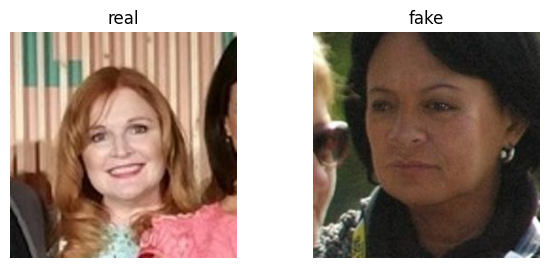

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = '/content/extracted_images/image/train'

# List all folders (classes) in the train directory
classes = os.listdir(train_dir)

plt.figure(figsize=(15,10))

for i, class_name in enumerate(classes, 1):
    folder = os.path.join(train_dir, class_name)
    # Assuming you want to display the 42nd image from each class folder
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(class_name)  # Assuming class_name represents emotion
    plt.axis('off')

plt.show()

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid, adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()


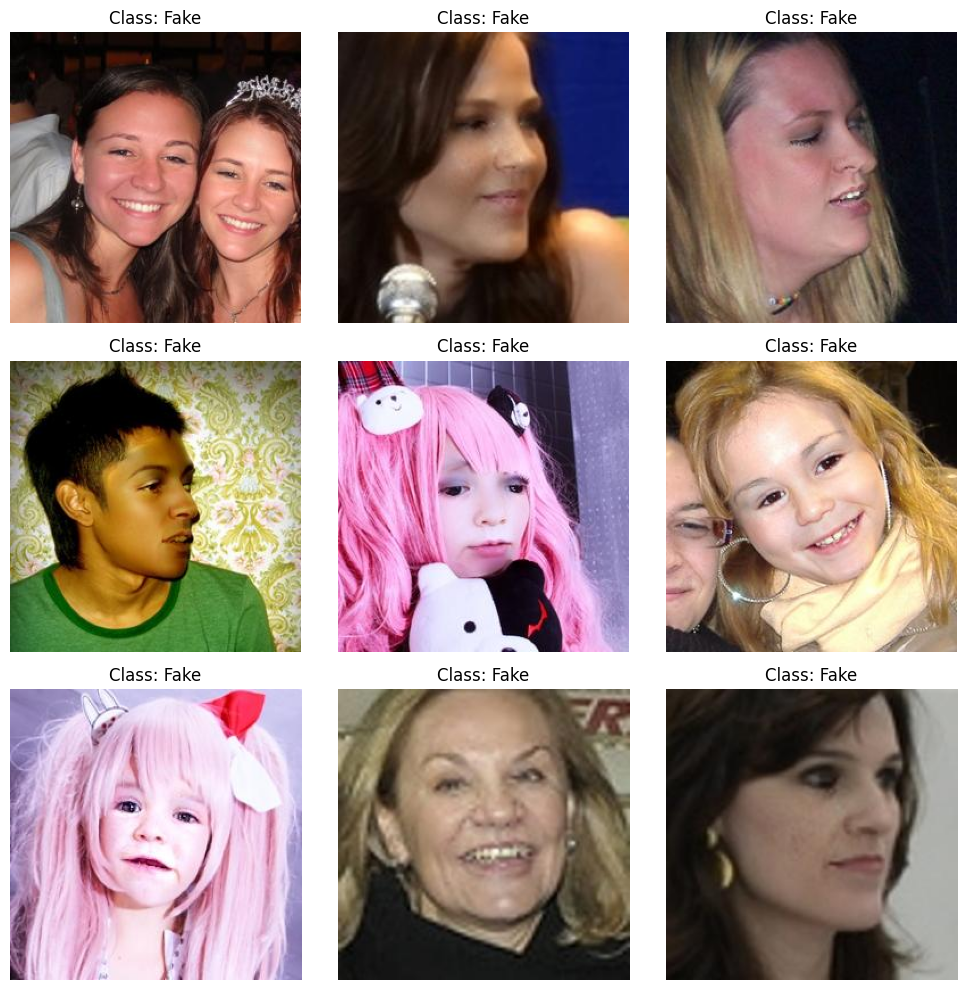

In [ ]:
# Corrected directory path
directory_path = '/content/extracted_images/image/train/fake'
class_name = 'Fake'  # Class name for 'fake' images

plot_images_from_directory(directory_path, class_name)

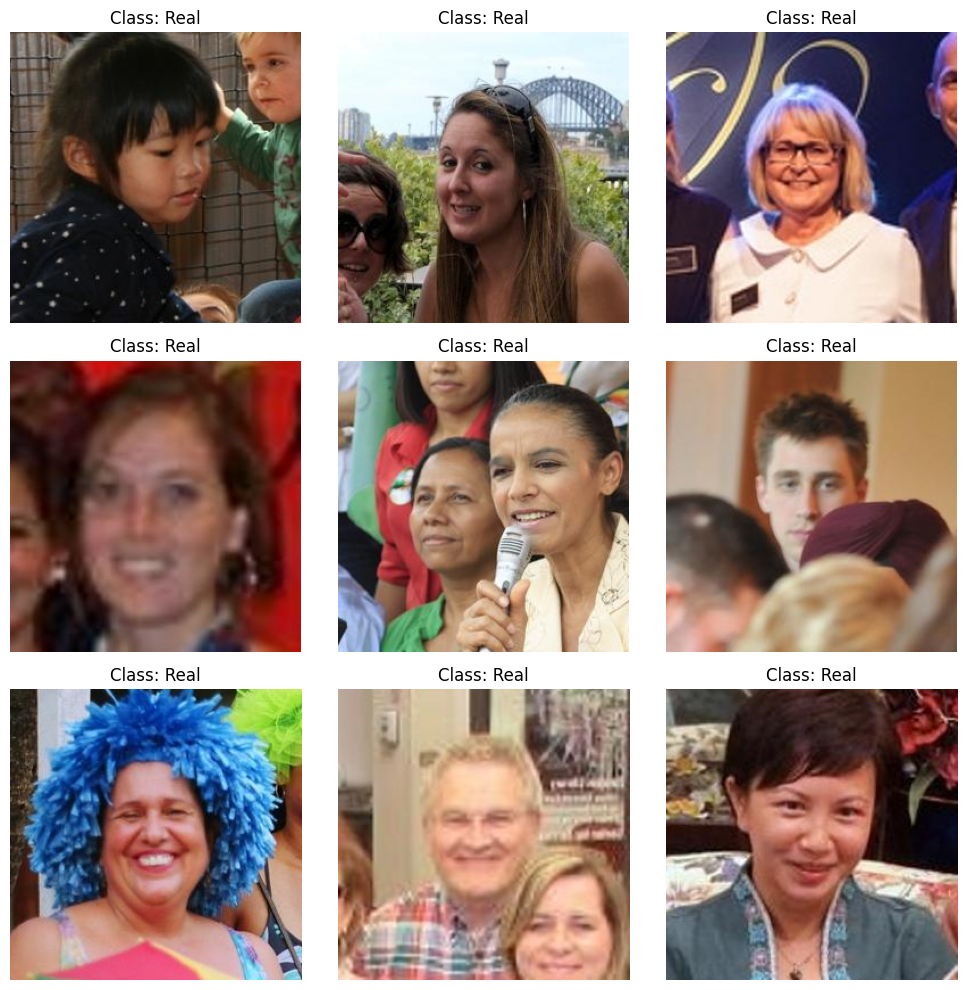

In [ ]:
# Corrected directory path
directory_path = '/content/extracted_images/image/train/real'
class_name = 'Real'  # Class name for 'fake' images

plot_images_from_directory(directory_path, class_name)

In [ ]:
import cv2

image_path = '/content/extracted_images/image/train/fake/fake_0.jpg'  # Updated image path

img = cv2.imread(image_path) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")


Shape: (256, 256, 3)


In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/extracted_images/image/train'
test_data_dir = '/content/extracted_images/image/test'


In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator

# Set some parameters
img_width, img_height = 150, 150  # Size of images
batch_size = 20
num_classes = 2

# Define paths to the train and validation directories
train_data_dir = '/content/extracted_images/image/train'
validation_data_dir = '/content/extracted_images/image/validation'  # New directory for validation data
test_data_dir = '/content/extracted_images/image/test'

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train, validation, and test sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Set class_mode to 'binary' for two classes
    color_mode='rgb',  # Set color_mode to 'rgb' for color images
    subset='training')

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Set class_mode to 'binary' for two classes
    color_mode='rgb',  # Set color_mode to 'rgb' for color images
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Set class_mode to 'binary' for two classes
    color_mode='rgb',  # Set color_mode to 'rgb' for color images
)



Found 3987 images belonging to 2 classes.
Found 3930 images belonging to 2 classes.
Found 3946 images belonging to 2 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'fake': 0, 'real': 1}
Validation class labels: {'fake': 0, 'real': 1}
Validation class labels: {'fake': 0, 'real': 1}


In [ ]:
images, labels = next(train_generator)
images, labels

(array([[[[0.3803922 , 0.3803922 , 0.3803922 ],
          [0.83921576, 0.83921576, 0.83921576],
          [0.86666673, 0.86666673, 0.86666673],
          ...,
          [0.25882354, 0.15686275, 0.15294118],
          [0.18431373, 0.12156864, 0.12156864],
          [0.10588236, 0.06666667, 0.07058824]],
 
         [[0.8431373 , 0.8431373 , 0.8431373 ],
          [0.87843144, 0.87843144, 0.87843144],
          [0.8588236 , 0.8588236 , 0.8588236 ],
          ...,
          [0.2509804 , 0.14901961, 0.14509805],
          [0.16078432, 0.09803922, 0.09803922],
          [0.09803922, 0.0509804 , 0.0509804 ]],
 
         [[0.86274517, 0.86274517, 0.86274517],
          [0.854902  , 0.854902  , 0.854902  ],
          [0.882353  , 0.882353  , 0.882353  ],
          ...,
          [0.25490198, 0.14509805, 0.14117648],
          [0.19215688, 0.12156864, 0.12156864],
          [0.12941177, 0.07450981, 0.07450981]],
 
         ...,
 
         [[0.3019608 , 0.2901961 , 0.3254902 ],
          [0.36470

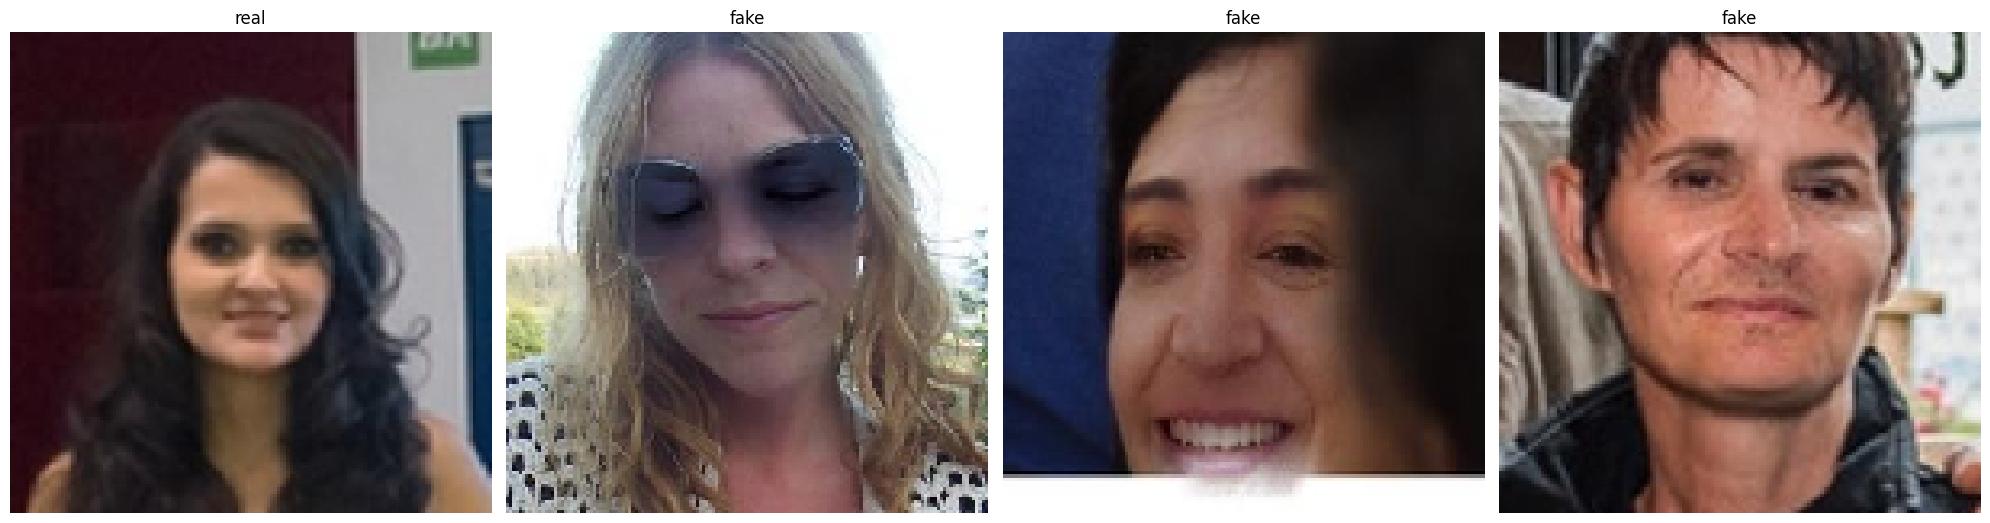

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [ ]:
train_generator.reset()

Basic CNN Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

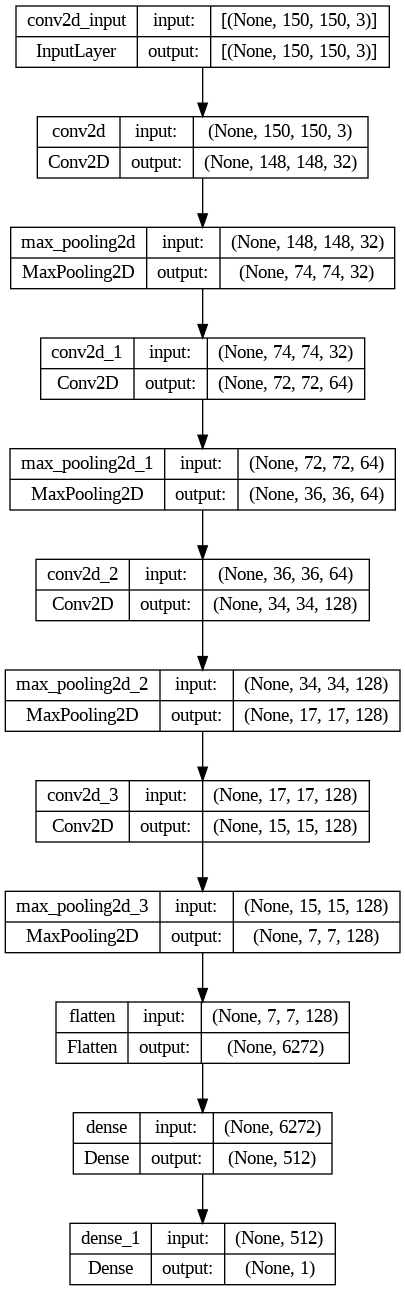

In [ ]:
plot_model(model, to_file = 'Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

200.0 197.0


In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=200)

Epoch 1/10
200/500 [===========>..................] - ETA: 9s - loss: 0.1051 - accuracy: 0.9584

500/500 [==============================] - 12s 23ms/step - loss: 0.1051 - accuracy: 0.9584 - val_loss: 0.5440 - val_accuracy: 0.8443


In [ ]:
history.history

{'loss': [0.2214283049106598,
  0.20180517435073853,
  0.21279191970825195,
  0.19870996475219727,
  0.16483967006206512,
  0.1553729921579361,
  0.15976959466934204,
  0.14882665872573853,
  0.1416020542383194,
  0.11021912097930908],
 'accuracy': [0.9209864139556885,
  0.9300453066825867,
  0.9214896559715271,
  0.9275000095367432,
  0.9340714812278748,
  0.9436336159706116,
  0.9355000257492065,
  0.9430000185966492,
  0.9470000267028809,
  0.9580000042915344]}

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=100
)


Epoch 1/10
200/200 [==============================] - 17s 83ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 1.1481 - val_accuracy: 0.8415
Epoch 2/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.9960 - val_accuracy: 0.8480
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 1.0814 - val_accuracy: 0.8715
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.8738 - val_accuracy: 0.8320
Epoch 5/10
200/200 [==============================] - 8s 40ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 1.0406 - val_accuracy: 0.8420
Epoch 6/10
200/200 [==============================] - 10s 48ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 1.0866 - val_accuracy: 0.8550
Epoch 7/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0115 - accuracy: 0.9957 - val_loss: 1.0347 - val_accuracy: 0.8

In [ ]:
history.history

{'loss': [0.0177504513412714,
  0.010213383473455906,
  0.01301073282957077,
  0.029328737407922745,
  0.019948497414588928,
  0.013250278308987617,
  0.01145410630851984,
  0.027598116546869278,
  0.01759723387658596,
  0.005026064347475767],
 'accuracy': [0.9942312240600586,
  0.9964885711669922,
  0.9962377548217773,
  0.9904690384864807,
  0.9929772019386292,
  0.995234489440918,
  0.9957361221313477,
  0.9897165894508362,
  0.9939804077148438,
  0.9979934692382812],
 'val_loss': [1.1481338739395142,
  0.9959851503372192,
  1.0814412832260132,
  0.8738169074058533,
  1.040626883506775,
  1.086551308631897,
  1.0347052812576294,
  1.1507049798965454,
  0.9055529832839966,
  0.9647749662399292],
 'val_accuracy': [0.8414999842643738,
  0.8479999899864197,
  0.8715000152587891,
  0.8320000171661377,
  0.8420000076293945,
  0.8550000190734863,
  0.8734999895095825,
  0.8385000228881836,
  0.8485000133514404,
  0.8604999780654907]}

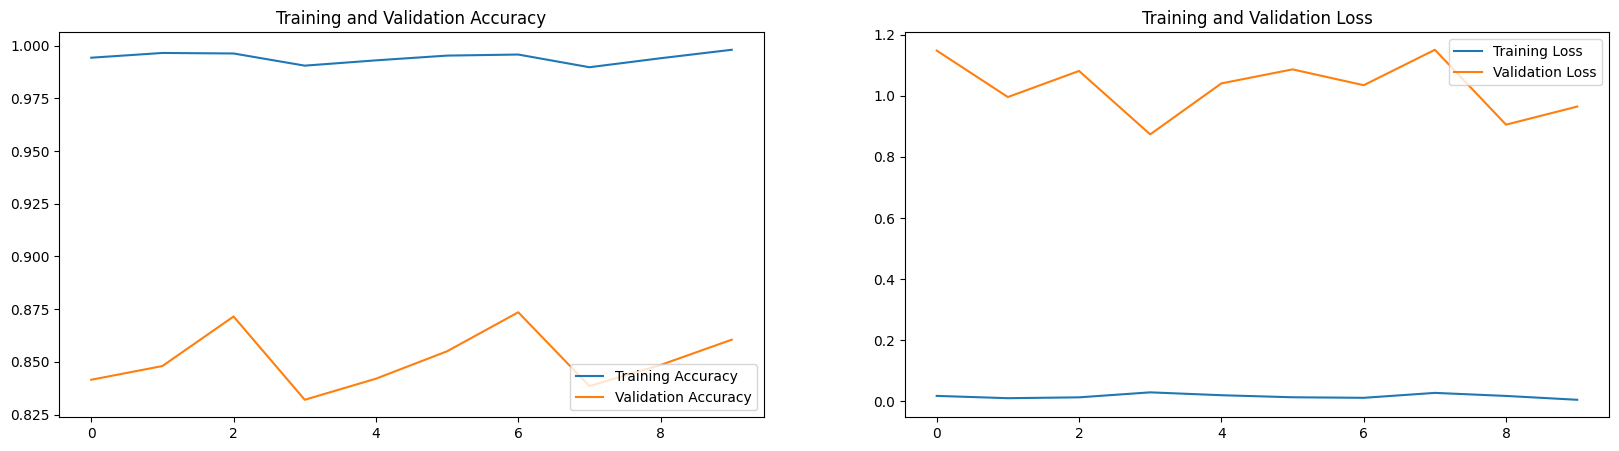

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Evaluation

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

test_dir = '/content/extracted_images/image/test'  # Path to your test directory

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Should match the input size of your network
    batch_size=20,  # Can adjust based on your memory constraints
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=False)  # No need to shuffle test data

Found 3946 images belonging to 2 classes.


In [ ]:
np.ceil(test_generator.samples/test_generator.batch_size)

198.0

In [ ]:
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))
probabilities

198/198 [==============================] - 6s 29ms/step


array([[9.9961495e-01],
       [9.3229979e-01],
       [3.1884987e-04],
       ...,
       [1.6771318e-06],
       [9.9989796e-01],
       [9.7610056e-01]], dtype=float32)

In [ ]:
# Reset the test generator
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes

# Predict probabilities for the positive class
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))

# The output is the probability of the positive class,
# so we will threshold it at 0.5 to decide the predicted class
predicted_classes = (probabilities > 0.5).astype(int).squeeze()


# Class labels are just [0, 1] for binary classification, or you can use custom labels if you have them
class_labels = list(test_generator.class_indices.keys())
predicted_classes

198/198 [==============================] - 4s 22ms/step


array([1, 1, 0, ..., 0, 1, 1])

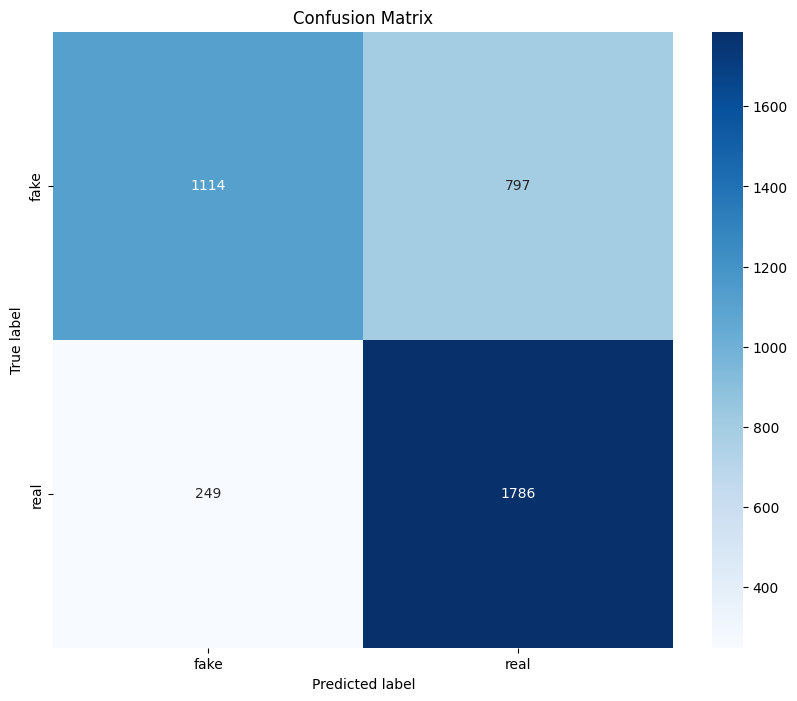

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

198/198 [==============================] - 7s 35ms/step - loss: 1.9415 - accuracy: 0.7349
Test accuracy: 73.49%
Test loss: 1.94


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def make_prediction(image_path):
    # Load the image
    img = load_img(image_path, target_size=(150, 150))  # Resizing the image

    # Convert the image to array and preprocess
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    # Make prediction
    prediction = model.predict(img_array)
    print("Prediction:", prediction)

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    if prediction[0][0] > 0.5:
        plt.title('Predicted: Real')
    else:
        plt.title('Predicted: Fake')
    plt.show()


1/1 [==============================] - 0s 29ms/step
Prediction: [[1.]]


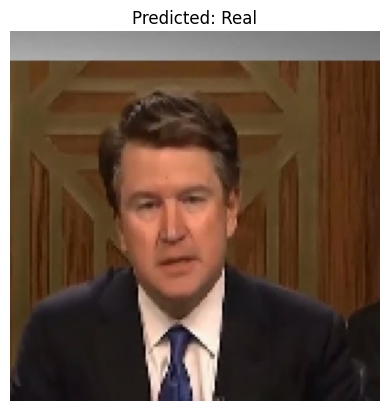

In [ ]:
# Load and preprocess the image
img_path = '/content/maxresdefaultfda.jpg'
make_prediction(img_path)

1/1 [==============================] - 0s 22ms/step
Prediction: [[1.]]


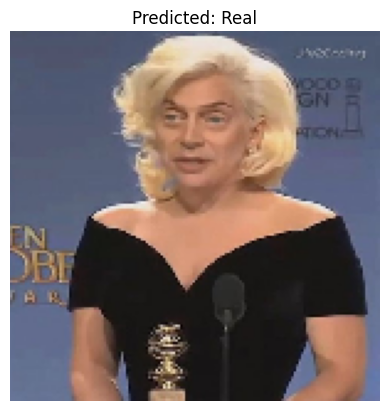

In [ ]:
# Load and preprocess the image
img_path = '/content/190729_dt_deepfake_hpMain_16x9_992.jpg'
make_prediction(img_path)

1/1 [==============================] - 0s 93ms/step
Prediction: [[1.]]


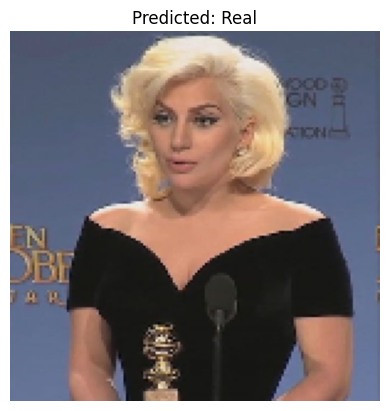

In [ ]:
# Load and preprocess the image
img_path = '/content/dsW.jpg'
make_prediction(img_path)

1/1 [==============================] - 0s 28ms/step
Prediction: [[0.9985096]]


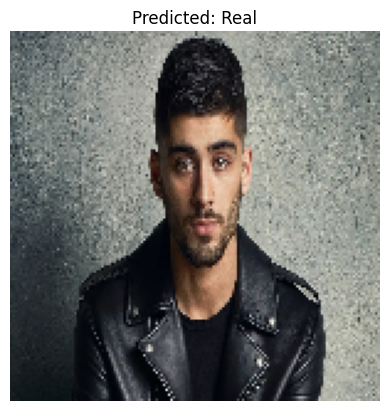

In [ ]:
# Load and preprocess the image
img_path = '/content/spl1416025_002.webp'
make_prediction(img_path)

In [ ]:
from tensorflow.keras import models, layers

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Now you can train your model using fit() function
# Example: model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

# Once your model is trained, you can save it to a file
model.save('my_model.h6')


In [ ]:
from google.colab import files

# Download the model file
files.download('my_model.h6')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from flask import Flask, render_template, request, jsonify
from flask_ngrok import run_with_ngrok
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

# Function to make predictions
def make_prediction(image_path):
    # Load the image
    img = load_img(image_path, target_size=(150, 150))  # Resizing the image

    # Convert the image to array and preprocess
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    # Make prediction (replace this with your actual model prediction code)
    prediction = "Fake" if image_path.endswith("fake.jpg") else "Real"
    return prediction

# Route for serving the index.html file
@app.route('/')
def index():
    return render_template('index.html')

# Route for handling image upload and making predictions
@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image found'})

    file = request.files['image']
    img_path = file.filename

    # Save the uploaded image
    file.save(img_path)

    # Make prediction
    prediction = make_prediction(img_path)

    # Delete the uploaded image
    os.remove(img_path)

    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-34:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [ ]:
from flask import Flask, render_template, request, jsonify
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

app = Flask(__name__)

# Load the trained model
model = load_model('my_model.h6')

def make_prediction(image_path):
    # Load the image
    img = load_img(image_path, target_size=(150, 150))  # Resizing the image

    # Convert the image to array and preprocess
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 1./255  # Rescale the image similarly as we did for the training data

    # Make prediction
    prediction = model.predict(img_array)
    return prediction[0][0] > 0.5

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get the uploaded file
    file = request.files['image']

    # Save the file
    file_path = 'uploaded_image.jpg'
    file.save(file_path)

    # Make prediction
    prediction = make_prediction(file_path)

    # Return prediction as JSON response
    return jsonify({'prediction': 'Real' if prediction else 'Fake'})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8881, debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8881
 * Running on http://172.28.0.12:8881
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:

from flask import Flask, render_template, request, jsonify
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

app = Flask(__name__)

# Load the trained model
model = load_model('my_model.h6')

def make_prediction(image_path):
    # Load the image
    img = load_img(image_path, target_size=(150, 150))  # Resizing the image

    # Convert the image to array and preprocess
    img_array = img_to_array(img)  # Converting to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Rescale the image similarly as we did for the training data

    # Make prediction
    prediction = model.predict(img_array)
    return prediction[0][0] > 0.5

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get the uploaded file
    file = request.files['image']

    # Save the file
    file_path = 'uploaded_image.jpg'
    file.save(file_path)

    # Make prediction
    prediction = make_prediction(file_path)

    # Return prediction as JSON response
    return jsonify({'prediction': 'Real' if prediction else 'Fake'})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8881, debug=True)
